In [1]:
# Imports
import os
import MDAnalysis as mda
from MDAnalysis.analysis.distances import distance_array
from MDAnalysis.analysis.dihedrals import Dihedral
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import random
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Load trajectories
uA = mda.Universe("protein.pdb", "5us_protein_only_center.xtc")
uB = mda.Universe("protein.pdb", "only_prot_center.xtc")

In [2]:
# config
Frames, LR, WD = 1000, 1e-3, 1e-5
Batch_size, encoding_dim, epochs = 16, 16, 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Model architecture
def build_encoder(input_dim, encoding_dim):
    return nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, encoding_dim),
        nn.ReLU()
    )

def build_decoder(encoding_dim, output_dim):
    return nn.Sequential(
        nn.Linear(encoding_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 128),   
        nn.ReLU(),
        nn.Linear(128, output_dim)
    )


class ProteinAutoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Feature extraction
def extract_distances(universe, num_frames):
    distances = []
    atoms = universe.select_atoms("name BB")
    for ts in universe.trajectory[:num_frames]:
        pos = atoms.positions
        dist = distance_array(pos, pos)
        triu = np.triu_indices(len(pos), k=1)
        distances.append(dist[triu].flatten())
    return np.stack(distances)


def extract_dihedrals(universe, num_frames):
    bb_atoms = universe.select_atoms("name BB")
    quadruplets1 = [bb_atoms[i:i+4] for i in range(len(bb_atoms) - 3)]
    quadruplets1 = [ag for ag in quadruplets1 if len(ag) == 4]
    quadruplets2 = [bb_atoms[i+1:i+5] for i in range(len(bb_atoms) - 2)]
    quadruplets2 = [ag for ag in quadruplets2 if len(ag) == 4]
    quadruplets3 = [bb_atoms[i+2:i+6] for i in range(len(bb_atoms) - 1)]
    quadruplets3 = [ag for ag in quadruplets3 if len(ag) == 4]
    quadruplets4 = [bb_atoms[i+3:i+7] for i in range(len(bb_atoms))]
    quadruplets4 = [ag for ag in quadruplets4 if len(ag) == 4]
    
    dih1 = Dihedral(quadruplets1).run(start=0, stop=num_frames)
    dih2 = Dihedral(quadruplets2).run(start=0, stop=num_frames)
    dih3 = Dihedral(quadruplets3).run(start=0, stop=num_frames)
    dih4 = Dihedral(quadruplets4).run(start=0, stop=num_frames)
    
    angles1 = np.nan_to_num(dih1.angles)
    angles2 = np.nan_to_num(dih2.angles)
    angles3 = np.nan_to_num(dih3.angles)
    angles4 = np.nan_to_num(dih4.angles)
    
    A = np.concatenate([np.cos(angles1), np.sin(angles1)], axis=1)
    B = np.concatenate([np.cos(angles2), np.sin(angles2)], axis=1)
    C = np.concatenate([np.cos(angles3), np.sin(angles3)], axis=1)
    D = np.concatenate([np.cos(angles4), np.sin(angles4)], axis=1)

    return np.hstack((A,B,C,D))
    

In [4]:
# Prepare data
angles_A = extract_dihedrals(uA, Frames)
angles_B = extract_dihedrals(uB, Frames)
distances_A = extract_distances(uA, Frames)
distances_B = extract_distances(uB, Frames)

# Combine
universe_A_features = np.hstack([distances_A, angles_A])
universe_B_features = np.hstack([distances_B, angles_B])
combined = np.vstack([universe_A_features, universe_B_features])

# Scaling
scaler = MinMaxScaler()
scaled = scaler.fit_transform(combined)

# Shuffle and split
idx = np.arange(combined.shape[0])
np.random.shuffle(idx)

split = int(combined.shape[0] * 0.8)
train_idx = idx[:split]
test_idx = idx[split:]

training_data = scaled[train_idx]
testing_data = scaled[test_idx]

# Save index for reproducibility
np.save("shuffle_idx.npy", idx)

In [5]:
# Convert to tensor and create DataLoader
train = torch.from_numpy(training_data).float()
dataset = TensorDataset(train)
loader = DataLoader(dataset, batch_size=Batch_size, shuffle=False)

input_dim = training_data.shape[1]

model = ProteinAutoencoder(
    build_encoder(input_dim, encoding_dim),
    build_decoder(encoding_dim, input_dim)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
criterion = nn.MSELoss()

# Training loop
train_losses = []
encoded_out = []
model.train()

for epoch in range(epochs):
    epoch_loss = 0
    all_preds = []
    all_targets = []

    for (batch_x,) in loader:
        batch_x = batch_x.to(device)

        encoded, decoded = model(batch_x)
        loss = criterion(decoded, batch_x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # For R² tracking
        all_preds.append(decoded.detach().cpu().numpy())
        all_targets.append(batch_x.detach().cpu().numpy())

    # Compute R² score
    preds = np.concatenate(all_preds).flatten()
    targets = np.concatenate(all_targets).flatten()
    ss_res = np.sum((targets - preds) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 1e-10 else 0.0

    avg_loss = epoch_loss / len(loader)
    train_losses.append(avg_loss)

    print(f"Epoch[{epoch+1:>3}/{epochs}] Loss: {avg_loss:.5f}, R²: {r2:.3f}")


Epoch[  1/500] Loss: 0.05878, R²: -0.661
Epoch[  2/500] Loss: 0.02544, R²: 0.281
Epoch[  3/500] Loss: 0.02384, R²: 0.326
Epoch[  4/500] Loss: 0.02351, R²: 0.336
Epoch[  5/500] Loss: 0.02207, R²: 0.376
Epoch[  6/500] Loss: 0.02146, R²: 0.394
Epoch[  7/500] Loss: 0.02063, R²: 0.417
Epoch[  8/500] Loss: 0.02039, R²: 0.424
Epoch[  9/500] Loss: 0.02034, R²: 0.425
Epoch[ 10/500] Loss: 0.02012, R²: 0.432
Epoch[ 11/500] Loss: 0.02003, R²: 0.434
Epoch[ 12/500] Loss: 0.01989, R²: 0.438
Epoch[ 13/500] Loss: 0.01975, R²: 0.442
Epoch[ 14/500] Loss: 0.01959, R²: 0.447
Epoch[ 15/500] Loss: 0.01954, R²: 0.448
Epoch[ 16/500] Loss: 0.01945, R²: 0.450
Epoch[ 17/500] Loss: 0.01955, R²: 0.448
Epoch[ 18/500] Loss: 0.01951, R²: 0.449
Epoch[ 19/500] Loss: 0.01931, R²: 0.454
Epoch[ 20/500] Loss: 0.01921, R²: 0.457
Epoch[ 21/500] Loss: 0.01912, R²: 0.460
Epoch[ 22/500] Loss: 0.01916, R²: 0.459
Epoch[ 23/500] Loss: 0.01930, R²: 0.455
Epoch[ 24/500] Loss: 0.01907, R²: 0.461
Epoch[ 25/500] Loss: 0.01901, R²: 0.463

KeyboardInterrupt: 

In [6]:
#Prepare test data
test = torch.from_numpy(testing_data).float()
test_dataset = TensorDataset(test)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False)

# Evaluation - FIXED VERSION
model.eval()
test_loss = 0.0
all_decoded = []
all_original = []
test_encoded_out = []

with torch.no_grad():
    for (batch_x,) in test_loader:  # Fixed: Only unpack one value
        batch_x = batch_x.to(device)

        encoded, decoded = model(batch_x)
        loss = criterion(decoded, batch_x)

        test_loss += loss.item()
        all_decoded.append(decoded.cpu().numpy())
        all_original.append(batch_x.cpu().numpy())
        test_encoded_out.append(encoded.cpu())

# Calculate metrics
avg_test_loss = test_loss / len(test_loader)
decoded_np = np.concatenate(all_decoded).flatten()
original_np = np.concatenate(all_original).flatten()
ss_res = np.sum((original_np - decoded_np) ** 2)
ss_tot = np.sum((original_np - original_np.mean()) ** 2)
r2_test = 1 - (ss_res / ss_tot) if ss_tot > 1e-10 else 0.0

# Combine encoded outputs
test_encoded_out = torch.cat(test_encoded_out, dim=0)

print(f"\n[Test] Loss: {avg_test_loss:.5f}, R²: {r2_test:.3f}")


[Test] Loss: 0.01865, R²: 0.466


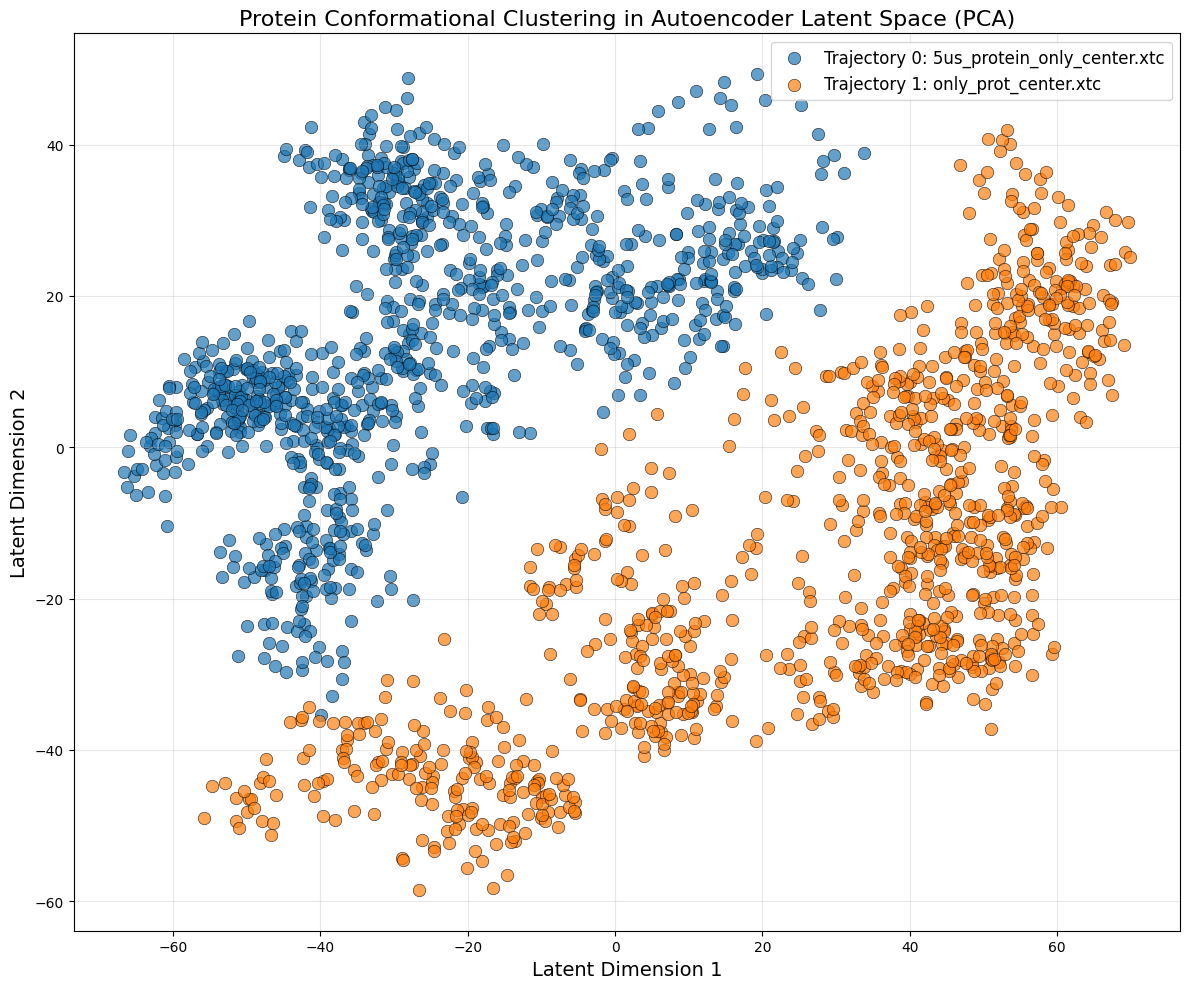

In [7]:
# Encode full dataset
model.eval()
data_tensor = torch.tensor(scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    encoded_data = model.encoder(data_tensor)

encoded_data_np = encoded_data.cpu().numpy()

# Define labels for A and B
labels = np.concatenate([
    np.zeros(universe_A_features.shape[0], dtype=int), 
    np.ones(universe_B_features.shape[0], dtype=int)
])

# PCA projection to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(encoded_data_np)

# Cluster plot
plt.figure(figsize=(12, 10))
colors = ['#1f77b4', '#ff7f0e']
trajectory_names = ['5us_protein_only_center.xtc', 'only_prot_center.xtc']

for traj_id in [0, 1]:
    mask = labels == traj_id
    plt.scatter(latent_2d[mask, 0],
                latent_2d[mask, 1],
                c=colors[traj_id],
                alpha=0.7,
                label=f'Trajectory {traj_id}: {trajectory_names[traj_id]}',
                s=80,
                edgecolors='k',
                linewidth=0.5)

plt.xlabel('Latent Dimension 1', fontsize=14)
plt.ylabel('Latent Dimension 2', fontsize=14)
plt.title('Protein Conformational Clustering in Autoencoder Latent Space (PCA)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Reconstruction R² Score: 0.4982


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


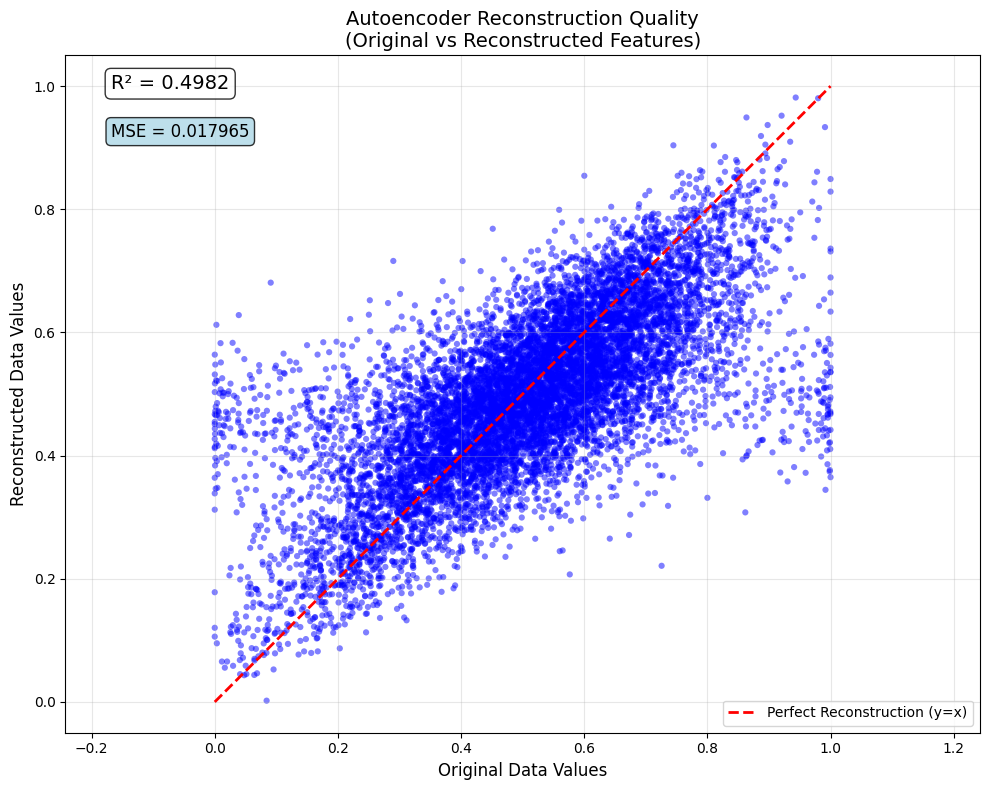


Reconstruction Statistics:
Original data shape: torch.Size([2000, 53237])
Reconstructed data shape: torch.Size([2000, 53237])
Mean Absolute Error: 0.096428
Root Mean Square Error: 0.133079
Original data range: [0.000, 1.000]
Reconstructed data range: [-0.103, 1.077]


In [8]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set random seed for reproducible sampling
np.random.seed(42)

# Get decoder and set to evaluation mode
decoder = model.decoder
decoder.eval()

# Make sure encoded_data is on the correct device
latent_tensor = encoded_data.to(device)

# Reconstruct data
with torch.no_grad():
    reconstructed_data = decoder(latent_tensor)

# Convert to numpy and flatten
reconstructed_flattened = reconstructed_data.cpu().numpy().flatten()
original_data_flattened = data_tensor.detach().cpu().numpy().flatten()

# Compute R²
r2 = r2_score(original_data_flattened, reconstructed_flattened)

print(f"Reconstruction R² Score: {r2:.4f}")

# Create the plot
plt.figure(figsize=(10, 8))

# Subsample for clarity (to avoid overcrowded plots)
n_points = min(10000, len(original_data_flattened))
sample_indices = np.random.choice(len(original_data_flattened), n_points, replace=False)
original_sample = original_data_flattened[sample_indices]
reconstructed_sample = reconstructed_flattened[sample_indices]

# Create scatter plot
plt.scatter(original_sample, reconstructed_sample, alpha=0.5, s=20, color='blue', edgecolors='none')

# Add perfect reconstruction line (y=x)
min_val = min(np.min(original_sample), np.min(reconstructed_sample))
max_val = max(np.max(original_sample), np.max(reconstructed_sample))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Reconstruction (y=x)')

# Add R² annotation
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes,
         fontsize=14, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add some statistics
mse = np.mean((original_sample - reconstructed_sample) ** 2)
plt.text(0.05, 0.88, f'MSE = {mse:.6f}', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Labels and formatting
plt.xlabel('Original Data Values', fontsize=12)
plt.ylabel('Reconstructed Data Values', fontsize=12)
plt.title('Autoencoder Reconstruction Quality\n(Original vs Reconstructed Features)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Set equal aspect ratio for better visualization
plt.axis('equal')

# Add some margin to the plot
data_range = max_val - min_val
margin = data_range * 0.05
plt.xlim(min_val - margin, max_val + margin)
plt.ylim(min_val - margin, max_val + margin)

plt.tight_layout()
plt.show()

# Print additional reconstruction statistics
print(f"\nReconstruction Statistics:")
print(f"Original data shape: {data_tensor.shape}")
print(f"Reconstructed data shape: {reconstructed_data.shape}")
print(f"Mean Absolute Error: {np.mean(np.abs(original_data_flattened - reconstructed_flattened)):.6f}")
print(f"Root Mean Square Error: {np.sqrt(np.mean((original_data_flattened - reconstructed_flattened) ** 2)):.6f}")
print(f"Original data range: [{np.min(original_data_flattened):.3f}, {np.max(original_data_flattened):.3f}]")
print(f"Reconstructed data range: [{np.min(reconstructed_flattened):.3f}, {np.max(reconstructed_flattened):.3f}]")